In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# Load dataset
data = pd.read_csv('dataset.csv')

In [3]:
# Rename columns
data.rename(columns={'Unnamed: 0': 'id', 'Title': 'name', 'Ingredients': 'ingredients',
                     'Instructions': 'steps', 'Image_Name': 'image'}, inplace=True)

In [4]:
# Pilih kolom yang relevan
new_data = data[['id', 'name', 'ingredients', 'steps', 'image']]

In [5]:
# Tambahkan kolom rating dengan nilai random antara 1-5
new_data['rating'] = [random.randint(1, 5) for _ in range(len(new_data))]

In [6]:
# Tambahkan kolom cluster dengan nilai random 0 atau 1
new_data['cluster'] = np.random.choice([0, 1], size=len(new_data), replace=True)
new_data['cluster_label'] = new_data['cluster'].map({0: 'biasa saja', 1: 'favorit'})

In [7]:
# **Gunakan TF-IDF lebih optimal**
tfidf = TfidfVectorizer(stop_words='english', max_features=20000, ngram_range=(1, 3))
X_ingredients = tfidf.fit_transform(new_data['ingredients'].values.astype('U'))

In [8]:
# **Optimasi jumlah cluster menggunakan Elbow Method**
wcss = []
for i in range(5, 15):  # Uji cluster dari 5 hingga 15
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_ingredients)
    wcss.append(kmeans.inertia_)

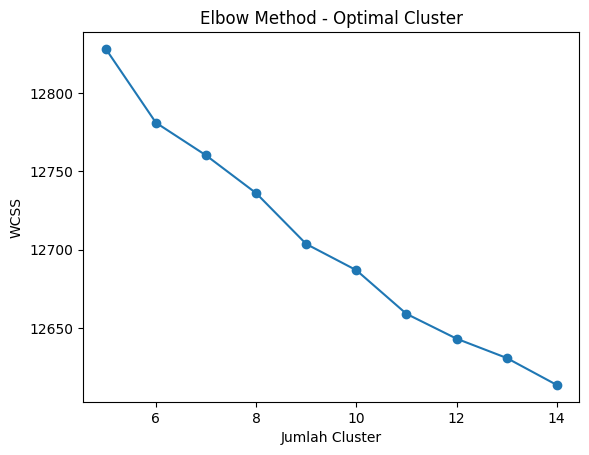

In [9]:
# Plot Elbow Method
plt.plot(range(5, 15), wcss, marker='o')
plt.xlabel("Jumlah Cluster")
plt.ylabel("WCSS")
plt.title("Elbow Method - Optimal Cluster")
plt.show()

In [10]:
# **Gunakan K-Means dengan cluster lebih optimal**
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
new_data['category_num'] = kmeans.fit_predict(X_ingredients)

In [12]:
# **Pemetaan kategori lebih rinci berdasarkan ingredients**
def categorize_food(ingredients):
    ingredients = ingredients.lower()
    
    # 🍖 Daging & Protein Hewani
    if any(item in ingredients for item in ['beef', 'lamb', 'pork', 'chicken', 'turkey', 'duck', 'bacon', 'sausage']):
        return "Meat-Based"
    elif any(item in ingredients for item in ['fish', 'shrimp', 'salmon', 'tuna', 'crab', 'mussels']):
        return "Seafood"
    
    # 🥦 Sayuran & Tanaman
    elif any(item in ingredients for item in ['spinach', 'kale', 'lettuce', 'broccoli', 'carrot', 'potato', 'tomato', 'cucumber', 'mushroom']):
        return "Vegetarian"

    # 🍚 Sumber Karbohidrat
    elif any(item in ingredients for item in ['rice', 'oats', 'quinoa', 'barley', 'flour', 'bread', 'pasta', 'tortilla', 'sweet potato']):
        return "Bakery"

    # 🍶 Produk Susu & Alternatifnya
    elif any(item in ingredients for item in ['milk', 'cheese', 'butter', 'yogurt', 'almond milk', 'soy milk']):
        return "Dairy-Based"

    # 🍯 Pemanis & Perasa
    elif any(item in ingredients for item in ['sugar', 'honey', 'maple syrup', 'stevia', 'salt', 'pepper', 'garlic', 'cinnamon', 'basil', 'oregano']):
        return "Seasoning & Sweetener"

    # 🍩 Dessert & Bahan Kue
    elif any(item in ingredients for item in ['chocolate', 'cocoa', 'vanilla', 'eggs', 'baking powder']):
        return "Dessert"
    
    # Jika tidak sesuai kategori di atas
    else:
        return "Other"

new_data['category'] = new_data['ingredients'].apply(categorize_food)

In [13]:
# **Gunakan Naïve Bayes dengan smoothing alpha lebih tinggi**
model_category = MultinomialNB(alpha=0.5)
model_category.fit(X_ingredients, new_data['category_num'])

MultinomialNB(alpha=0.5)

In [14]:
# **Gunakan TF-IDF lebih kuat untuk rekomendasi nama**
cv = TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1, 3))
X_name = cv.fit_transform(new_data['name'].values.astype('U'))

In [15]:
model_recommendation = MultinomialNB(alpha=0.5)
y = np.arange(len(new_data))
model_recommendation.fit(X_name, y)

MultinomialNB(alpha=0.5)

In [16]:
# **Fungsi pencarian kategori dengan hasil acak**
def search_by_category(category_name, N=5):
    matching_items = new_data[new_data['category'] == category_name]
    print(f"Makanan acak dalam kategori '{category_name}':")
    print(matching_items.sample(frac=1).head(N)[['id', 'name', 'ingredients', 'category', 'rating', 'cluster_label']])

In [17]:
# **Fungsi pencarian berdasarkan cluster dengan hasil acak**
def search_by_cluster(cluster_label, N=5):
    matching_items = new_data[new_data['cluster_label'] == cluster_label]
    print(f"Makanan acak dalam cluster '{cluster_label}':")
    print(matching_items.sample(frac=1).head(N)[['id', 'name', 'ingredients', 'category', 'rating', 'cluster_label']])

In [18]:
# **Fungsi rekomendasi berdasarkan nama makanan**
def recommend_nb(name):
    query_vec = cv.transform([name.lower()])
    predicted_probs = model_recommendation.predict_proba(query_vec)[0]
    top_5_indices = np.argsort(predicted_probs)[-5:][::-1]

    recommended_items = new_data.iloc[top_5_indices].copy()
    recommended_items['predicted_category'] = recommended_items['ingredients'].apply(categorize_food)

    print("Rekomendasi untuk:", name)
    print(recommended_items[['id', 'name', 'ingredients', 'category', 'predicted_category', 'rating', 'cluster_label']])

In [19]:
# **Tes pencarian berdasarkan kategori (acak)**
search_by_category("Dessert")

Makanan acak dalam kategori 'Dessert':
          id                            name  \
11066  11066  Chocolate-Orange Cookie Stacks   
7531    7531                    Monster Pops   
4295    4295      Ghostly Chocolate-Nut Bark   
11712  11712                  Ramos Gin Fizz   
10819  10819                    Stout Floats   

                                             ingredients category  rating  \
11066  ['1 cup chilled heavy whipping cream', '2/3 cu...  Dessert       2   
7531   ['48 uncoated Basic Cake Balls , chilled', '64...  Dessert       2   
4295   ['1 cup roughly chopped walnuts', '1 cup rough...  Dessert       1   
11712  ['1 1/2 ounces gin (such as Taaka or Tanqueray...  Dessert       5   
10819  ['2 pints superpremium vanilla ice cream', '6 ...  Dessert       4   

      cluster_label  
11066    biasa saja  
7531        favorit  
4295        favorit  
11712       favorit  
10819    biasa saja  


In [20]:
# **Tes pencarian berdasarkan cluster (acak)**
search_by_cluster("favorit")


Makanan acak dalam cluster 'favorit':
        id                                               name  \
5108  5108  Modern Salade Lyonnaise with Leeks, Lardons, a...   
9817  9817                     Steak, Tomato, and Okra Kebabs   
1444  1444           Vanilla Heart Cakes with Rosewater Icing   
560    560                           Beef and Ginger Stir-Fry   
3312  3312                       French Toast Turkey Sandwich   

                                            ingredients  \
5108  ['8 ounces chicken livers (about 12), trimmed'...   
9817  ['3 tablespoons finely chopped shallot', '3 ta...   
1444  ['1 x quantity One-Bowl Vanilla Cake batter', ...   
560   ['1 lb. skirt steak, trimmed, sliced against t...   
3312  ['6 slices thick-cut bacon', '2 tablespoons li...   

                   category  rating cluster_label  
5108             Meat-Based       5       favorit  
9817             Meat-Based       5       favorit  
1444  Seasoning & Sweetener       2       favorit  
560     

In [21]:
# **Tes pencarian berdasarkan nama makanan**
target_item = "BURGER"
recommend_nb(target_item)

Rekomendasi untuk: BURGER
        id                       name  \
5509  5509  The Burger Lover's Burger   
9656  9656              Aussie Burger   
7020  7020              Pete's Burger   
3790  3790            Insanity Burger   
6956  6956        The Trifecta Burger   

                                            ingredients    category  \
5509  ['1 1/2 pounds well-marbled beef chuck top bla...  Meat-Based   
9656  ['1/4 cup ketchup', '1/4 cup mayonnaise', '1 t...  Meat-Based   
7020  ['4 slices aged Cheddar cheese', '1 onion, cut...  Meat-Based   
3790  ['1 3/4 lbs ground chuck steak', 'Olive oil', ...  Meat-Based   
6956  ['1 cup (96 g) TVP granules', '1 cup (235 ml) ...      Bakery   

     predicted_category  rating cluster_label  
5509         Meat-Based       5       favorit  
9656         Meat-Based       4       favorit  
7020         Meat-Based       2    biasa saja  
3790         Meat-Based       3       favorit  
6956             Bakery       1       favorit  


In [25]:
accuracy_category = model_category.score(X_ingredients, new_data['category_num'])
print(f"Akurasi Model Kategori Naïve Bayes: {accuracy_category:.2%}")


Akurasi Model Kategori Naïve Bayes: 90.29%


In [26]:
accuracy_recommendation = model_recommendation.score(X_name, y)
print(f"Akurasi Model Rekomendasi Nama: {accuracy_recommendation:.2%}")


Akurasi Model Rekomendasi Nama: 96.77%


In [27]:
print(new_data['category'].value_counts())


category
Meat-Based               3382
Bakery                   2811
Vegetarian               2399
Seasoning & Sweetener    1921
Dairy-Based              1595
Seafood                   843
Other                     481
Dessert                    69
Name: count, dtype: int64


In [28]:
recommend_nb("Pizza")
recommend_nb("Cake")
recommend_nb("Smoothie")
recommend_nb("Burger")


Rekomendasi untuk: Pizza
          id                    name  \
6245    6245        Gardener's Pizza   
1420    1420             Salad Pizza   
13023  13023           Apple "Pizza"   
8504    8504      "Pizza" Sandwiches   
5667    5667  Veggi-Prosciutto Pizza   

                                             ingredients    category  \
6245   ['Generous pinch of sugar', '1 1/4 cups/300 ml...  Vegetarian   
1420   ['1 pound store-bought pizza dough,room temper...  Vegetarian   
13023  ['1 frozen puff pastry sheet (from a 17 1/4-oz...      Bakery   
8504   ['4 tablespoons extra-virgin olive oil plus ad...  Vegetarian   
5667   ['1 package (16 ounces) frozen whole-wheat piz...  Vegetarian   

      predicted_category  rating cluster_label  
6245          Vegetarian       5       favorit  
1420          Vegetarian       1    biasa saja  
13023             Bakery       4    biasa saja  
8504          Vegetarian       4    biasa saja  
5667          Vegetarian       5       favorit  
Rekomen